In [9]:
#Additional Packages to Install
!pip install pydrive
!pip install git+https://github.com/hyperopt/hyperopt.git
!pip install kopt
!pip install oauth2client
!pip install tensorboardcolab
!pip install pymongo
!pip install git+https://github.com/rthalley/dnspython.git
!pip install dnspython

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import pydrive
import pymongo
import dns
from tensorboardcolab import *
from random import randint
from keras.layers import Dense,Conv1D,Input
from keras.layers import MaxPooling1D,UpSampling1D
from keras.layers import Activation,BatchNormalization
from keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from sklearn.preprocessing import MinMaxScaler
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from kopt import CompileFN, KMongoTrials, test_fn
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.mongoexp import MongoTrials
from google.colab import drive






  Cloning https://github.com/hyperopt/hyperopt.git to /tmp/pip-req-build-7dwiva7g
  Running command git clone -q https://github.com/hyperopt/hyperopt.git /tmp/pip-req-build-7dwiva7g
  Running command git submodule update --init --recursive -q
  Cloning https://github.com/rthalley/dnspython.git to /tmp/pip-req-build-1ab1b8iu
  Running command git clone -q https://github.com/rthalley/dnspython.git /tmp/pip-req-build-1ab1b8iu
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [38]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)


def plot_multiclass_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    cmap = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    Z = model.predict_classes(np.c_[xx.ravel(), yy.ravel()], verbose=0)
    Z = Z.reshape(xx.shape)
    fig = plt.figure(figsize=(8, 8))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
def plot_data(X, y, figsize=None):
    if not figsize:
        figsize = (8, 6)
    plt.figure(figsize=figsize)
    plt.plot(X[y==0, 0], X[y==0, 1], 'or', alpha=0.5, label=0)
    plt.plot(X[y==1, 0], X[y==1, 1], 'ob', alpha=0.5, label=1)
    plt.xlim((min(X[:, 0])-0.1, max(X[:, 0])+0.1))
    plt.ylim((min(X[:, 1])-0.1, max(X[:, 1])+0.1))
    plt.legend()

def plot_loss_accuracy(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, max(1, historydf.values.max())))
    loss = history.history['loss'][-1]
    acc = history.history['accuracy'][-1]
    plt.title('Loss: %.3f, Accuracy: %.3f' % (loss, acc))

def plot_loss(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, historydf.values.max()))
    plt.title('Loss: %.3f' % history.history['loss'][-1])

**Application of DAE : Denoising-Medical-Images**

Due to advancement in technology we might have a large amount of the data but there is always concern about the usability. For example, in medical images like X-rays, MRI, CT scans, Ultrasound, etc., when original images are put in the paper, the quality degrades, due to which the accuracy of the decision model degrades. These images are susceptible to noise.

Image denoising is required to suppress noise from noise-contaminated images,and hence, is an important preprocessing step in image analysis. There are many different techniques and methods which can be used for performing denoising such as applying Median, Gaussian, Average, Bilateral Filters, etc. However, they don't necessarily perform well in denoising images without losing much information and hence, an algorithm is needed that can outperform all the other methods that have been proposed.

In [11]:
import numpy as np
import pandas as pd
import os
from keras.preprocessing import image
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D,MaxPool2D ,UpSampling2D, Flatten, Input
from keras.layers import Dense,Conv1D,Input
from keras.layers import MaxPooling1D,UpSampling1D
from keras.layers import Activation,BatchNormalization
from keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from sklearn.preprocessing import MinMaxScaler
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from kopt import CompileFN, KMongoTrials, test_fn
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.mongoexp import MongoTrials
from google.colab import drive
from keras import backend as K
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import cv2
from math import log10,sqrt

In [12]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [13]:
train_images=sorted(os.listdir('gdrive/My Drive/COVID'))


In [14]:
train_image=[]
for im in train_images:
  img=image.load_img('gdrive/My Drive/COVID/'+im,target_size=(64,64),color_mode='grayscale')
  img=image.img_to_array(img)
  img=img/255
  train_image.append(img)

train_df=np.array(train_image)

In [15]:
#Subplotting images
def plot_img(dataset):
  f,ax=plt.subplots(1,5)
  f.set_size_inches(40,20)
  for i in range(5,10):
    ax[i-5].imshow(dataset[i].reshape(64,64), cmap='gray')
  plt.show()

In order to create the training set, we purposely corrupt the images by adding noise to them stochastically with a random normal distribution having a mean of 0 and standard deviation of 1 with a multiplying factor of 0.07 as the dataset by default contains images without noise. This is done to stimulate the noise which can occur in medical images due to the reasons mentioned in the previous section.

In [16]:
#Adding gaussian noise with 0.07 factor
def add_noise(image):
  row,col,ch=image.shape
  mean=0
  sigma=1
  gauss=np.random.normal(mean,sigma,(row,col,ch))
  gauss=gauss.reshape(row,col,ch)
  noisy=image+gauss*0.07
  return noisy

In [17]:
noised_df=[]
for img in train_df:
  noisy=add_noise(img)
  noised_df.append(noisy)

noised_df=np.array(noised_df)

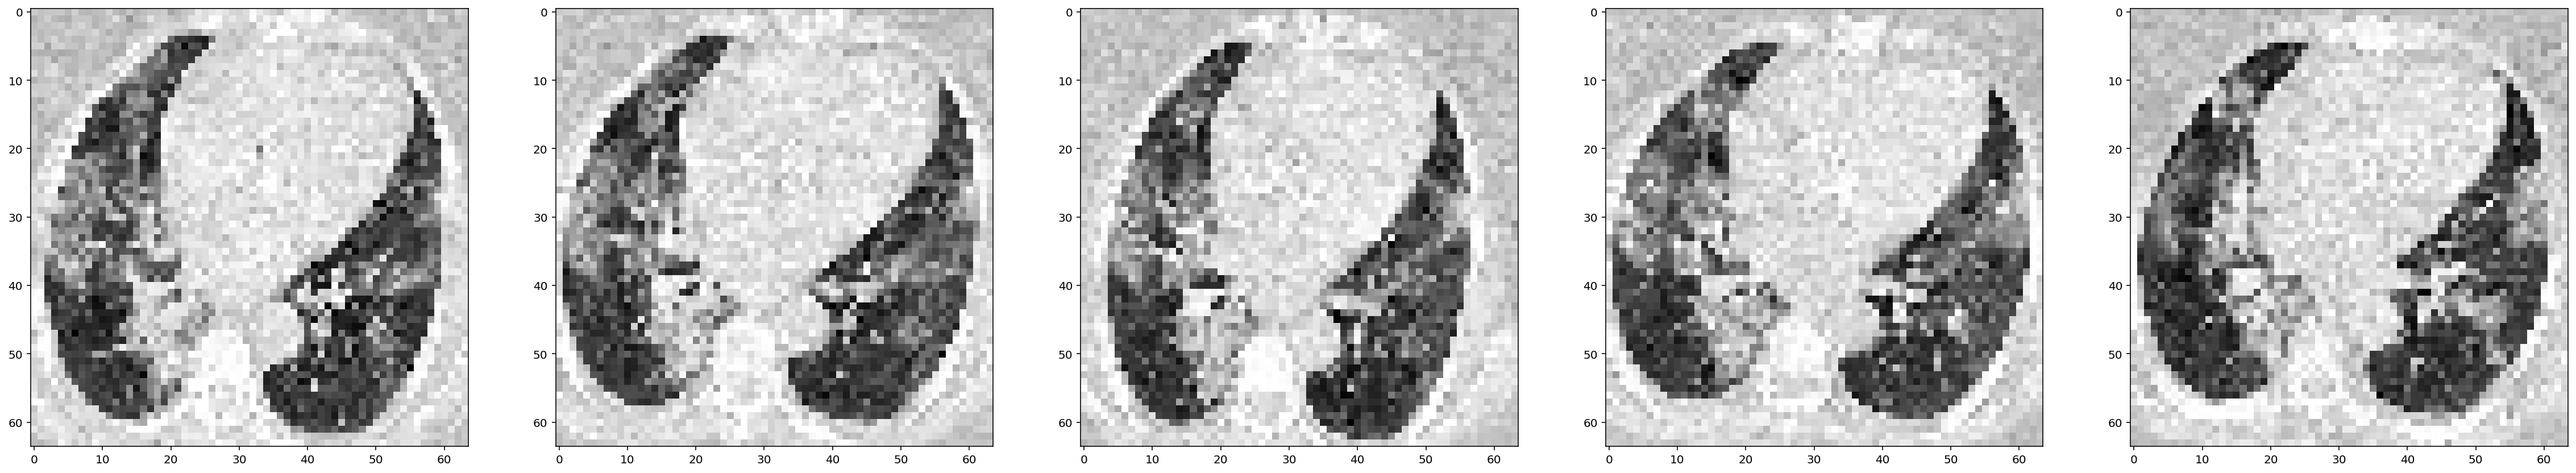

In [18]:
plot_img(train_df)


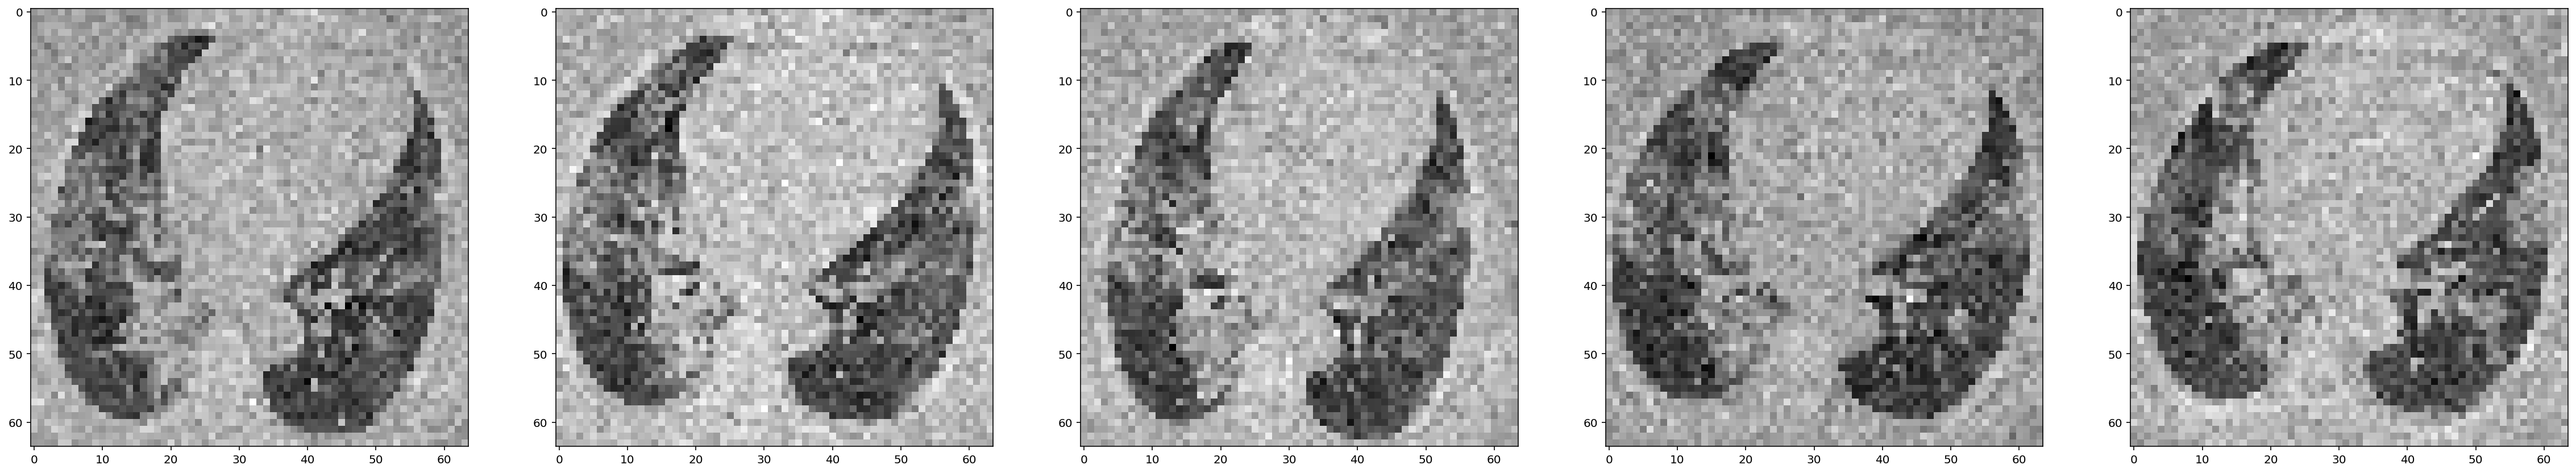

In [19]:
plot_img(noised_df)


In [20]:
xnoised=noised_df[:400]
xtest=noised_df[400:]

**Autoencoder** is a type of unsupervised learning technique that uses artificial neural networks for the task of representation learning. An autoencoder is made up of two parts- **Encoder**- It accepts the input data and maps it to a latent space, which is a compressed form of the data, using deterministic mapping. **Decoder**- It accepts the latent space representation and then maps it back into reconstruction, which has the same shape as the input data using similar mapping.

In [21]:
def autoencoder():
  input_img=Input(shape=(64,64,1),name='image_input')
  #enoder 
  x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1')(input_img)
  x = MaxPooling2D((2,2), padding='same', name='pool1')(x)
  x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv2')(x)
  x = MaxPooling2D((2,2), padding='same', name='pool2')(x)
   
  #decoder
  x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv3')(x)
  x = UpSampling2D((2,2), name='upsample1')(x)
  x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv4')(x)
  x = UpSampling2D((2,2), name='upsample2')(x)
  x = Conv2D(1, (3,3), activation='sigmoid', padding='same', name='Conv5')(x)
   
  #model
  autoencoder = Model(inputs=input_img, outputs=x)
  autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    
  return autoencoder

In [22]:
model= autoencoder()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 64, 64, 1)]       0         
                                                                 
 Conv1 (Conv2D)              (None, 64, 64, 64)        640       
                                                                 
 pool1 (MaxPooling2D)        (None, 32, 32, 64)        0         
                                                                 
 Conv2 (Conv2D)              (None, 32, 32, 64)        36928     
                                                                 
 pool2 (MaxPooling2D)        (None, 16, 16, 64)        0         
                                                                 
 Conv3 (Conv2D)              (None, 16, 16, 64)        36928     
                                                                 
 upsample1 (UpSampling2D)    (None, 32, 32, 64)        0     

In [26]:
with tf.device('/device:GPU:0'):
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
    historyy=model.fit(xnoised, xnoised, epochs=50, batch_size=10, validation_data=(xtest, xtest), callbacks=[early_stopping])

Epoch 1/50
40/40 [==============================] - 13s 330ms/step - loss: 0.4749 - val_loss: 0.4732
Epoch 2/50
40/40 [==============================] - 13s 331ms/step - loss: 0.4747 - val_loss: 0.4731
Epoch 3/50
40/40 [==============================] - 13s 327ms/step - loss: 0.4748 - val_loss: 0.4730
Epoch 4/50
40/40 [==============================] - 13s 330ms/step - loss: 0.4741 - val_loss: 0.4727
Epoch 5/50
40/40 [==============================] - 13s 331ms/step - loss: 0.4737 - val_loss: 0.4725
Epoch 6/50
40/40 [==============================] - 13s 330ms/step - loss: 0.4747 - val_loss: 0.4742
Epoch 7/50
40/40 [==============================] - 13s 333ms/step - loss: 0.4742 - val_loss: 0.4726
Epoch 8/50
40/40 [==============================] - 13s 332ms/step - loss: 0.4745 - val_loss: 0.4746
Epoch 9/50
40/40 [==============================] - 13s 332ms/step - loss: 0.4740 - val_loss: 0.4722
Epoch 10/50
40/40 [==============================] - 13s 331ms/step - loss: 0.4737 - val_lo

<Figure size 576x432 with 0 Axes>

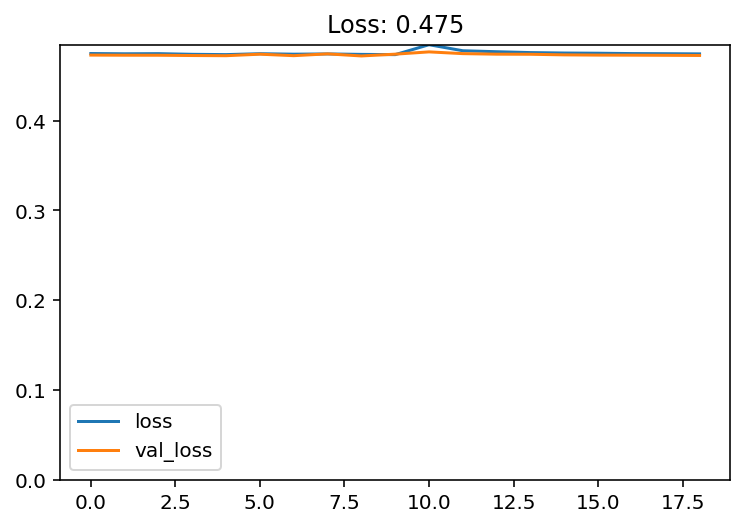

In [28]:
xtrain= train_df[100:]
plot_loss(historyy)


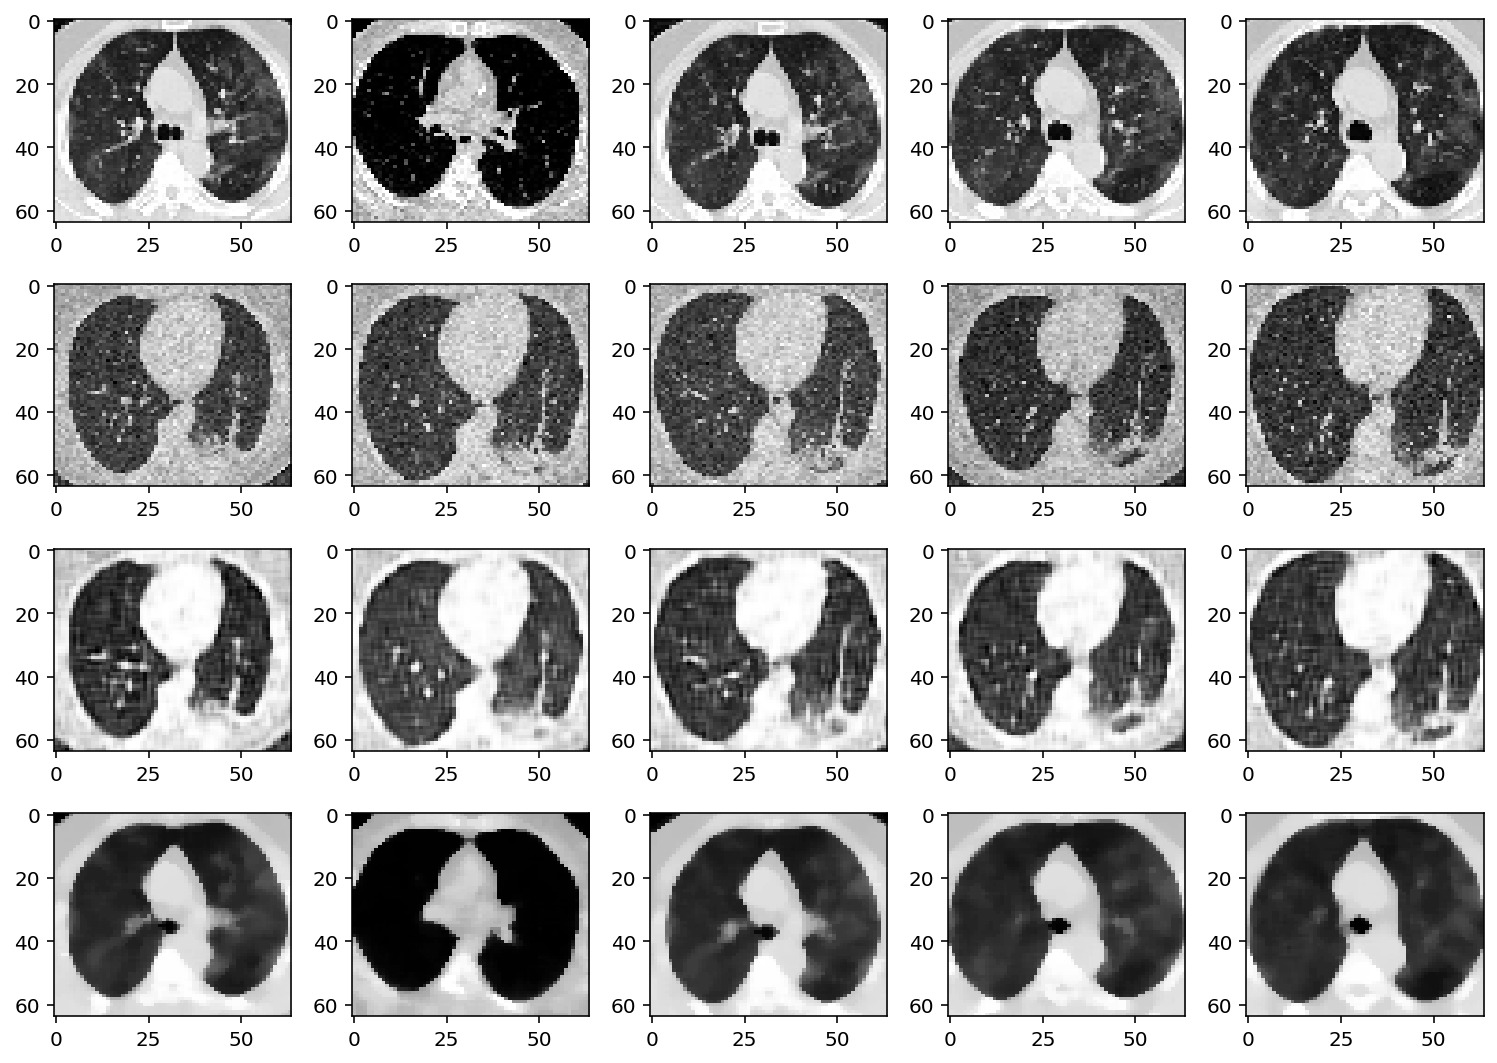

In [29]:
pred= model.predict(xtest[:5])
def plot_predictions(y_true, y_pred):    
    f, ax = plt.subplots(4, 5)
    f.set_size_inches(10.5,7.5)
    for i in range(5):
        ax[0][i].imshow(np.reshape(xtrain[i], (64,64)), aspect='auto', cmap='gray')
        ax[1][i].imshow(np.reshape(y_true[i], (64,64)), aspect='auto', cmap='gray')
        ax[2][i].imshow(np.reshape(y_pred[i], (64,64)), aspect='auto', cmap='gray')
        ax[3][i].imshow(cv2.medianBlur(xtrain[i], (5)), aspect='auto', cmap='gray')
    plt.tight_layout()
plot_predictions(xtest[:5], pred[:5])

Text(0.5, 1.0, 'Bilateral Filter')

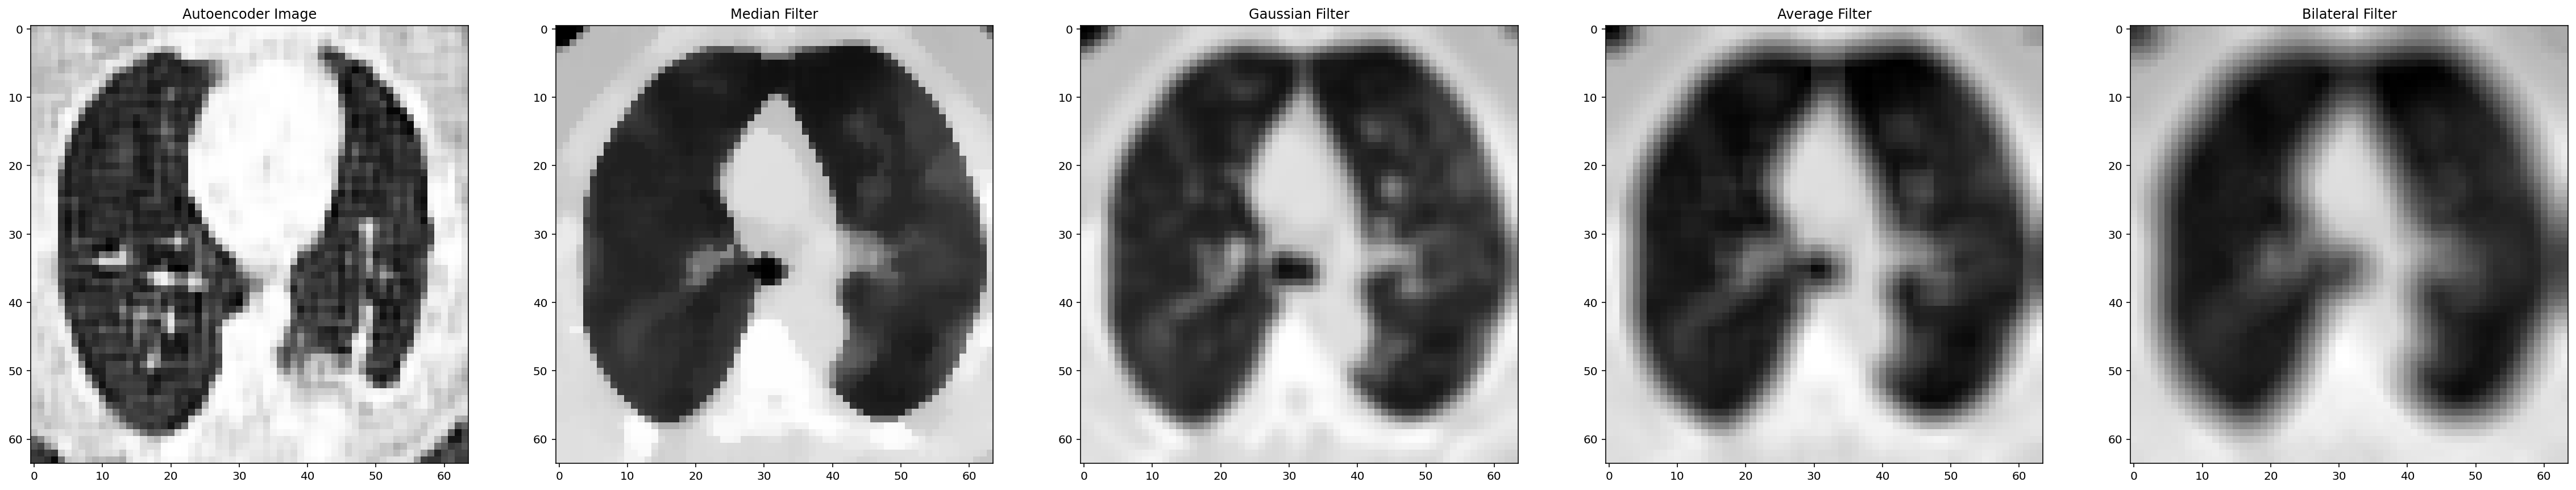

In [30]:
median_blur = cv2.medianBlur(xtrain[0], (5))
gaussian_blur=cv2.GaussianBlur(xtrain[0],(5,5),0)
average_blur=cv2.blur(xtrain[0],(5,5))
bilateral_filter=cv2.bilateralFilter(xtrain[0],9,75,75)
f,ax=plt.subplots(1,5)
f.set_size_inches(40,20)
ax[0].imshow(pred[0].reshape(64,64), cmap='gray')
ax[0].set_title('Autoencoder Image')
ax[1].imshow(median_blur,cmap='gray')
ax[1].set_title('Median Filter')
ax[2].imshow(gaussian_blur,cmap='gray')
ax[2].set_title('Gaussian Filter')
ax[3].imshow(average_blur,cmap='gray')
ax[3].set_title('Average Filter')
ax[4].imshow(bilateral_filter,cmap='gray')
ax[4].set_title('Bilateral Filter')

In [31]:
def PSNR(original, denoised): 
    mse = np.mean((original - denoised) ** 2) 
    if(mse == 0): 
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr 

  
value1 = PSNR(xtest[0], median_blur)
value2 = PSNR(xtest[0], pred[0])
value3 = PSNR(xtest[0], gaussian_blur)
value4 = PSNR(xtest[0], average_blur)
value5 = PSNR(xtest[0], bilateral_filter)

print("PSNR values")
print(f"Autoencoder Image : {value2} dB")
print(f"Median Filter Image : {value1} dB")
print(f"Gaussian Filter Image : {value3} dB")
print(f"Average Filter Image : {value4} dB")
print(f"Bilateral Filter Image : {value5} dB")

PSNR values
Autoencoder Image : 68.47015385204413 dB
Median Filter Image : 56.62716037100674 dB
Gaussian Filter Image : 56.91152557819951 dB
Average Filter Image : 57.06227018628515 dB
Bilateral Filter Image : 57.24748362527633 dB


 **Deep Denoising Autoencoder for Seismic Random Noise Attenuation**

An ideal denoising technique reconstructs the seismic signal and removes all the random
noise from the input seismic data. Let s(t) be the clean seismic signal, and n(t) be the
random noise. In practice, d(t) = s(t)+n(t) is the input seismic data. The denoised section
of the ideal denoising technique should be s(t), while the removed noise section should be
n(t). We propose obtaining the optimum parameters for the DDAE to act as a denoising
filter. The input, noise, encoder, decoder and output layers are the main layers of the
DAE. First, for the input layer, each sample of the clean signal, s(t), is stored in one
neuron. Second, for the noise layer, the random noise, n(t) is added to the clean seismic
signal, s(t), the output of this layer is d(t) = s(t) + n(t). Third, for the encoder layer,
the input seismic data, d(t), is compressed into multiple levels of abstraction to extract the
signifcant features, f(t), from the input seismic data. Fourth, for the decoder layer, the
DAE attempts to reconstruct the clean seismic signal, s(t) using the extracted features,
f(t). The decoder layer has the same architecture as the encoder layer with a reversed
order. In this way, the DAE learns to remove the undesirable random noise, n(t), from the
seismic data, d(t), and the reconstructed section, S R(t), is considered as the clean seismic
signal, s(t).

In [35]:
import tensorflow as tf 
from keras.layers import Input, Dense, Dropout, concatenate, UpSampling1D, Flatten, MaxPooling1D, BatchNormalization, average
from keras.models import Model
import scipy.io
from keras import optimizers
from keras import backend as K
from tensorflow.python.keras import backend as KK
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
)


import tensorflow as tf
import numbers
from tensorflow.python.framework import ops
from tensorflow.python.ops import standard_ops
from math import*


import numpy as np
import matplotlib.pyplot as plt

corr1=0
corr2=1
corr3=1
win = 256

mat = scipy.io.loadmat ('./DDAE_SYN.mat')
dataNoise = mat['dn'] 
dataNoise = np.transpose(dataNoise)
dataNoise = np.reshape(dataNoise,(256,int(np.shape(dataNoise)[0]*np.shape(dataNoise)[1]/win )))
dataNoise = np.transpose(dataNoise)
dataNoise = np.reshape(dataNoise, (dataNoise.shape[0],dataNoise.shape[1]))

dataNoise1= mat['d']
dataNoise1 = np.transpose(dataNoise1)
dataNoise1 = np.reshape(dataNoise1,(256,int(np.shape(dataNoise1)[0]*np.shape(dataNoise1)[1]/256 )))
dataNoise1 = np.transpose(dataNoise1)
dataNoise1 = np.reshape(dataNoise1, (dataNoise1.shape[0],dataNoise1.shape[1]))


INPUT_SIZE1 = dataNoise.shape[0]
INPUT_SIZE2 = dataNoise.shape[1]
 
input_img = Input(shape=(INPUT_SIZE2,))


encoded1 = Dense(512, activation='relu')(input_img)
encoded2 = Dense(256, activation='relu')(encoded1)
encoded3 = Dense(128, activation='relu' )(encoded2)


decoded1 = Dense(128, activation='relu' )(encoded3)
decoded2 = Dense(256, activation='relu')(decoded1)
decoded3 = Dense(512, activation='relu' )(decoded2)


decoded = Dense(INPUT_SIZE2, activation='linear')(decoded3)


autoencoder = Model(input_img, decoded)
sgd = tf.keras.optimizers.Adam(lr=0.001)
autoencoder.compile(optimizer=sgd, loss='mse',  metrics=['accuracy'])


autoencoder.summary()


batch =64


history = autoencoder.fit(dataNoise,dataNoise1, epochs=50, batch_size=batch, shuffle=True)


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256)]             0         
                                                                 
 dense_14 (Dense)            (None, 512)               131584    
                                                                 
 dense_15 (Dense)            (None, 256)               131328    
                                                                 
 dense_16 (Dense)            (None, 128)               32896     
                                                                 
 dense_17 (Dense)            (None, 128)               16512     
                                                                 
 dense_18 (Dense)            (None, 256)               33024     
                                                                 
 dense_19 (Dense)            (None, 512)               1315

<Figure size 576x432 with 0 Axes>

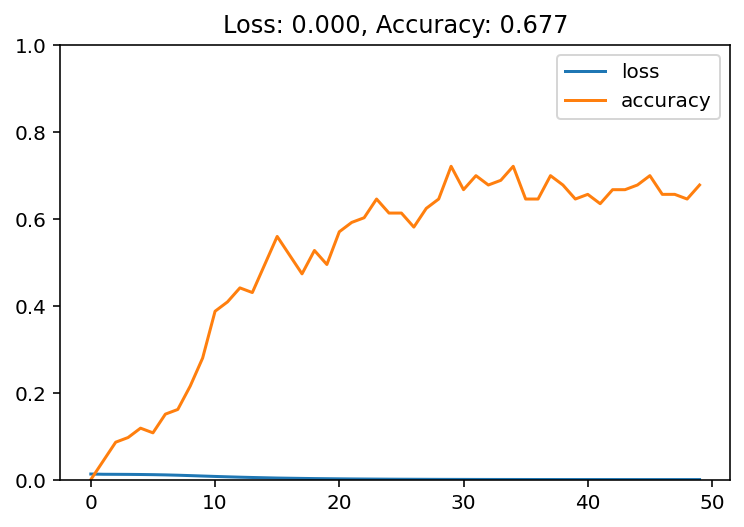

In [39]:
plot_loss_accuracy(history)



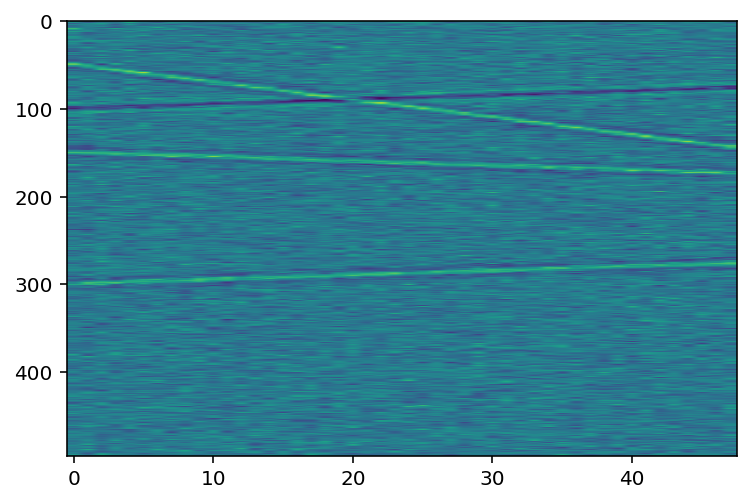

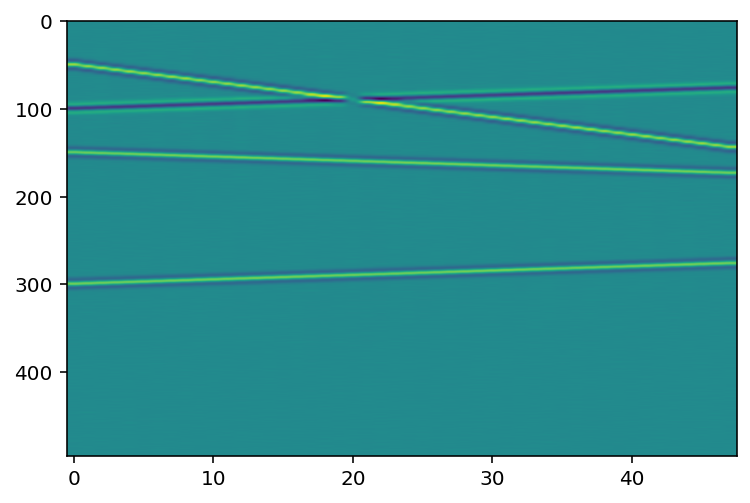

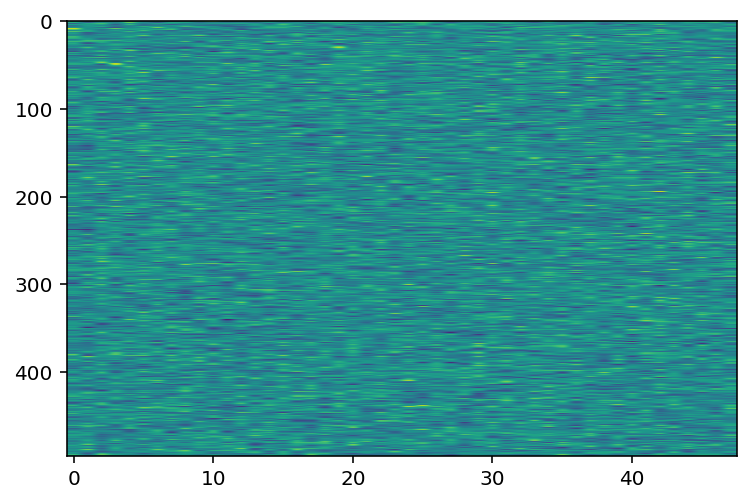

In [40]:
mat = scipy.io.loadmat ('./DDAE_SYN.mat')
dataNoise = mat['dn'] 
dataNoise = np.transpose(dataNoise)
dataNoise = np.reshape(dataNoise,(256,int(np.shape(dataNoise)[0]*np.shape(dataNoise)[1]/win )))
dataNoise = np.transpose(dataNoise)
dataNoise = np.reshape(dataNoise, (dataNoise.shape[0],dataNoise.shape[1]))
out = autoencoder.predict(dataNoise)

dataNoise = mat['dn'] 
dataNoise = np.transpose(dataNoise)
out = np.transpose(out)
out = np.reshape(out,(np.shape(dataNoise)[0], np.shape(dataNoise)[1])) 
plt.imshow(np.transpose(dataNoise), aspect = 'auto')
plt.figure() 
plt.imshow(np.transpose(out), aspect = 'auto')
plt.figure()
plt.imshow(np.transpose(dataNoise) - np.transpose(out), aspect = 'auto')

In [41]:
from keras.models import model_from_json
from keras.models import load_model

model_json = autoencoder.to_json()
with open("bestInitial_syn.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
autoencoder.save_weights("bestInitial_synW.h5")
print("Saved model to disk")

Saved model to disk


In [42]:
from keras.models import model_from_json
from keras.models import load_model

# load json and create model
json_file = open('bestInitial_syn.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
DDAE = model_from_json(loaded_model_json)

# load weights into new model
DDAE.load_weights("bestInitial_synW.h5")
print("Loaded model from disk")

Loaded model from disk


In [44]:
from keras.layers import Input, Dense, Dropout, concatenate, UpSampling1D, Flatten, MaxPooling1D, BatchNormalization, Average, Lambda, Conv1D,LeakyReLU
from keras.models import Model
import scipy.io
from keras import optimizers
from keras import backend as K
from tensorflow.python.keras import backend as KK
from keras.callbacks import EarlyStopping
import tensorflow as tf
import numbers
from tensorflow.python.framework import ops
from tensorflow.python.ops import standard_ops
from math import*
import numpy as np
import matplotlib.pyplot as plt



corr1=0
corr2=1
corr3=1

mat = scipy.io.loadmat ('./NEWREAL3_1.mat')
dataNoise = mat['dn1'] 
dataNoise = np.transpose(dataNoise)
dataNoise = np.reshape(dataNoise, (dataNoise.shape[0],dataNoise.shape[1]))

INPUT_SIZE1 = dataNoise.shape[0]
INPUT_SIZE2 = dataNoise.shape[1]

 
input_img = Input(shape=(INPUT_SIZE2,))


# Encoder
encoded1 = Dense(512, activation = 'relu')(input_img)
encoded2 = Dense(256, activation = 'relu')(encoded1)
encoded3 = Dense(128, activation = 'relu')(encoded2)

# Decoder
decoded1 = Dense(128, activation = 'relu')(encoded3)
decoded2 = Dense(256, activation = 'relu')(decoded1)
decoded3 = Dense(512, activation = 'relu')(decoded2)

# Final Layer
decoded = Dense(INPUT_SIZE2, activation='linear')(decoded3)




def correlation_coefficient_loss(y_true, y_pred):
    #optional
    x = y_true - y_pred
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x-mx, y-my
    r_num = K.sum(tf.multiply(xm,ym))
    r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym))))
    r = r_num / r_den
    r =  corr1 -r
    
    #1
    x1 = y_true
    y1 = y_pred
    mx1 = K.mean(x1)
    my1 = K.mean(y1)
    xm1, ym1 = x1-mx1, y1-my1
    r_num1 = K.sum(tf.multiply(xm1,ym1))
    r_den1 = K.sqrt(tf.multiply(K.sum(K.square(xm1)), K.sum(K.square(ym1))))
    r1 = r_num1 / r_den1
    r1 = corr2 -  r1
    
    # Optional
    '''  
    x2 = y_true-y_pred
    y2 = y_true
    mx2 = K.mean(x2)
    my2 = K.mean(y2)
    xm2, ym2 = x2-mx2, y2-my2
    r_num2 = K.sum(tf.multiply(xm2,ym2))
    r_den2 = K.sqrt(tf.multiply(K.sum(K.square(xm2)), K.sum(K.square(ym2))))
    r2 = r_num2 / r_den2
    r2 =    corr3 - (K.maximum(K.minimum(r2, 1.0), -1.0))
    '''
    return   K.square(r1) + K.square(r)
        

                    

autoencoder = Model(input_img, decoded)
sgd = tf.keras.optimizers.Adam(lr=0.001)
autoencoder.compile(optimizer=sgd, loss=[correlation_coefficient_loss])
#autoencoder.compile(optimizer=sgd, loss='mse')

autoencoder.summary()


batch =INPUT_SIZE2

# Initialization of the DDAE parameters using the parameters obtained by the synthetic example,
#in the paper we use more than one synthetich examples to obtain these parameters. However, here, 
#we just show the flow of the DDAE by using only one synthetic example. 

for i in range(2,7):
    w = DDAE.layers[i].get_weights()
    autoencoder.layers[i].set_weights(w)
    

history = autoencoder.fit(dataNoise,dataNoise, epochs=500, batch_size=batch, shuffle=True)


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 512)]             0         
                                                                 
 dense_28 (Dense)            (None, 512)               262656    
                                                                 
 dense_29 (Dense)            (None, 256)               131328    
                                                                 
 dense_30 (Dense)            (None, 128)               32896     
                                                                 
 dense_31 (Dense)            (None, 128)               16512     
                                                                 
 dense_32 (Dense)            (None, 256)               33024     
                                                                 
 dense_33 (Dense)            (None, 512)               1315

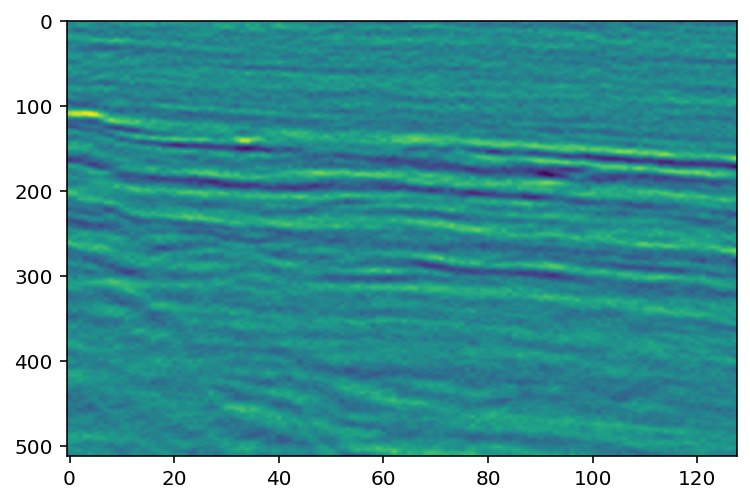

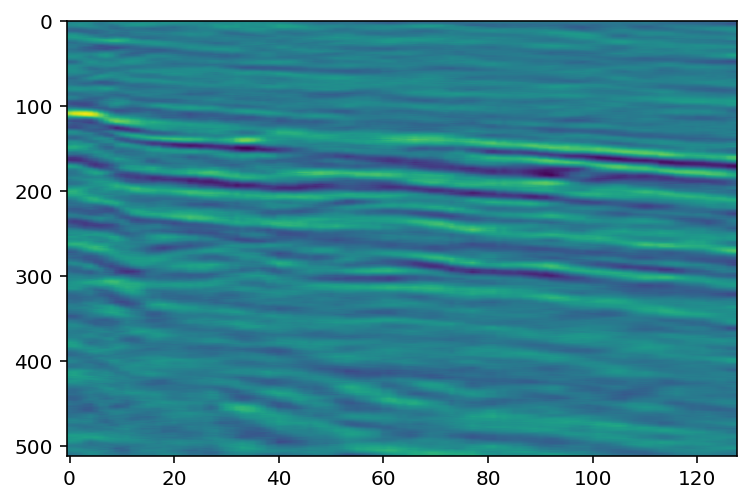

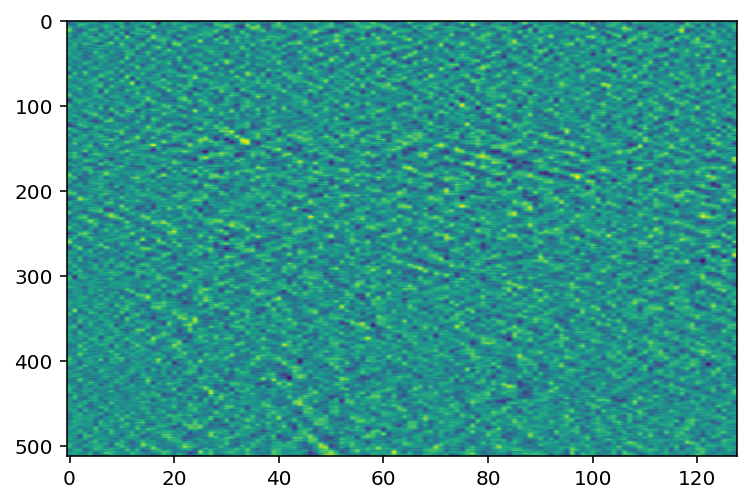

In [45]:
out = autoencoder.predict(dataNoise)
plt.imshow(np.transpose(dataNoise), aspect = 'auto')
plt.figure()
plt.imshow(np.transpose(out), aspect = 'auto')
plt.figure()
plt.imshow(np.transpose(dataNoise) - np.transpose(out ), aspect = 'auto')